In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
from tensorflow import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -q '/content/drive/MyDrive/XRAY/MURA-v1.1.zip' -d '/content/'

unzip:  cannot find or open /content/drive/MyDrive/XRAY/MURA-v1.1.zip, /content/drive/MyDrive/XRAY/MURA-v1.1.zip.zip or /content/drive/MyDrive/XRAY/MURA-v1.1.zip.ZIP.


In [6]:
def filenames(part,train=True):
    root='/content/'
    if train:
        csv_path=root+"MURA-v1.1/train_image_paths.csv"
    else:
        csv_path=root+"MURA-v1.1/valid_image_paths.csv"

    with open(csv_path, 'rb') as F:
        d = F.readlines()
#         print(str(d[0],encoding='utf-8').strip())
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

#     imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
#     print("self testing:",imgs[:5],labels[:5])
    return imgs,labels

In [ ]:
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy,startx:startx+cropx]

In [ ]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
# from albumentations.augmentations.transforms import Resize
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1,
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    ToFloat(max_value=255)
])
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1,
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    ToFloat(max_value=255)
]
root='/content/MURA-v1.1'
chosen_image= imread(root+'/train/XR_SHOULDER/patient00002/study1_positive/image1.png')
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img= resize(chosen_image,(300,300,3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img,224,224))

img_matrix_list.insert(0,chosen_image)

titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
               "Shift Scale Rotate","Resizing", "Cropping"]

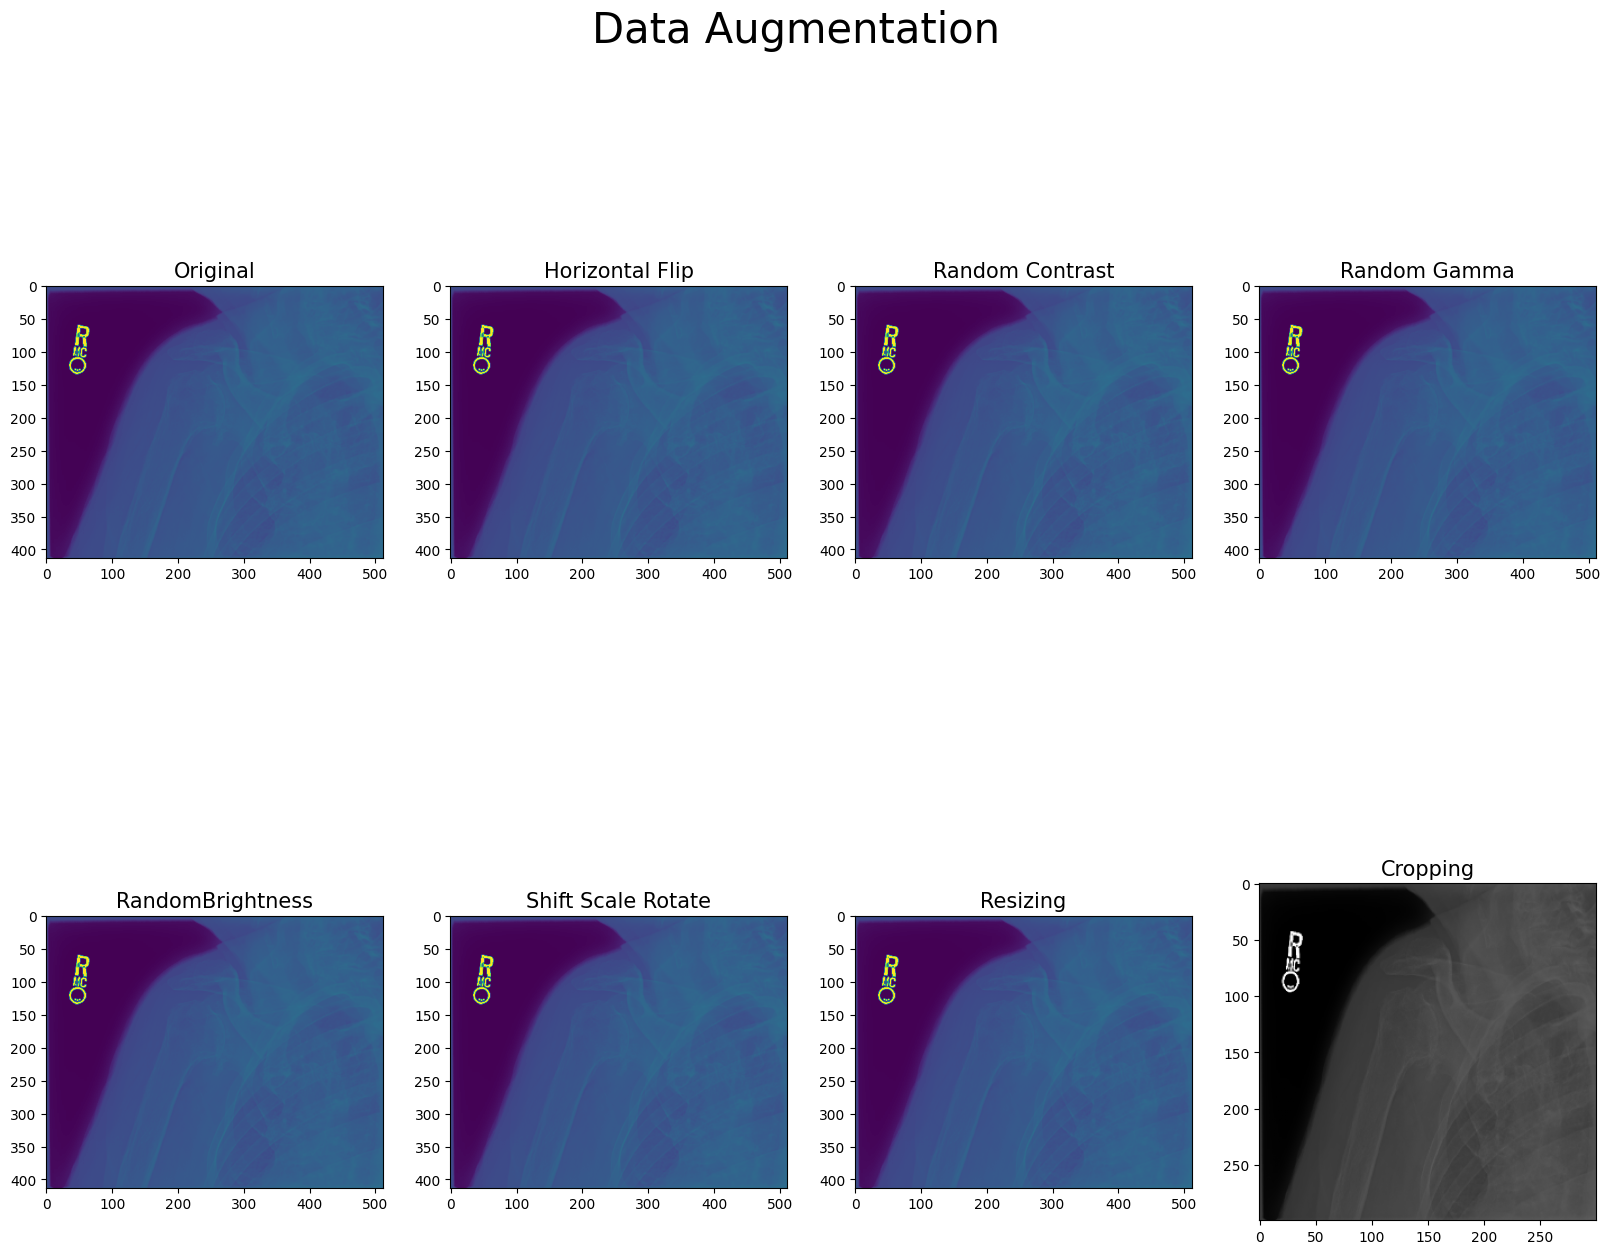

In [ ]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize = 30)
    #fig.subplots_adjust(wspace=0.3)
    #fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

plot_multiple_img(img_matrix_list, titles_list, ncols = 4)

In [ ]:
class My_Custom_Generator(keras.utils.Sequence) :
    def __init__(self, image_filenames, labels, batch_size,transform) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.t= transform

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
        x=[]
        for file in batch_x:
            img= imread(file)
            img= self.t(image=img)["image"]
            img= resize(img,(300,300,3))
            img= crop_center(img,224,224)
            x.append(img)
        x=np.array(x)/255.0
        y= np.array(batch_y)
        return x,y

In [ ]:
part='XR_SHOULDER'
imgs,labels= filenames(part=part)
vimgs,vlabels= filenames(part=part,train=False)
print(labels.count('positive'),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print("Training Data: ", training_data)
y_data= [0 if x=='positive' else 1 for x in labels]
# print(y_data[-1:-5:-1])
y_data= keras.utils.to_categorical(y_data)
# print(y_data[-1:-5:-1])
print(vlabels.count('positive'),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print("Validation Data: ", validation_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= keras.utils.to_categorical(vy_data)

4168 4211
Training Data:  8379
278 285
Validation Data:  563


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_data, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
batch_size = 128
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

In [ ]:
part='XR_SHOULDER'
checkpoint_path = "SHOULDER.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True,
                                       save_weights_only=False, mode='auto'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=3,
                                         min_delta=0.001, verbose=1, min_lr=0.000000001)]

In [ ]:
# with tpu_strategy.scope():
Inception=tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x=Inception (input_image)

x=keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Flatten()(x)

x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x=keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)


model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

print(model.summary())

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 activation_94 (Activation)  (None, 256)               0      

In [ ]:
my_callbacks,d_class_weights

([<keras.src.callbacks.ModelCheckpoint at 0x7ec3ca256ec0>,
 {0: 1.005158349328215, 1: 0.9948943243885063})

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(my_training_batch_generator,
                    steps_per_epoch=int(training_data // batch_size),
                    epochs=18,
                    verbose=1,
                    class_weight=d_class_weights,
                    validation_data=my_validation_batch_generator,
                    validation_steps=int(validation_data // batch_size),
                    callbacks=my_callbacks)



<ipython-input-10-19ef2a2aa6c8>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/18
65/65 [==============================] - ETA: 0s - loss: 0.7281 - accuracy: 0.5151  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


65/65 [==============================] - 4231s 64s/step - loss: 0.7281 - accuracy: 0.5151 - val_loss: 0.7046 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 2/18
65/65 [==============================] - 4157s 64s/step - loss: 0.6759 - accuracy: 0.5656 - val_loss: 0.7299 - val_accuracy: 0.4570 - lr: 0.0010
Epoch 3/18
62/65 [===========================>..] - ETA: 3:08 - loss: 0.6504 - accuracy: 0.6197

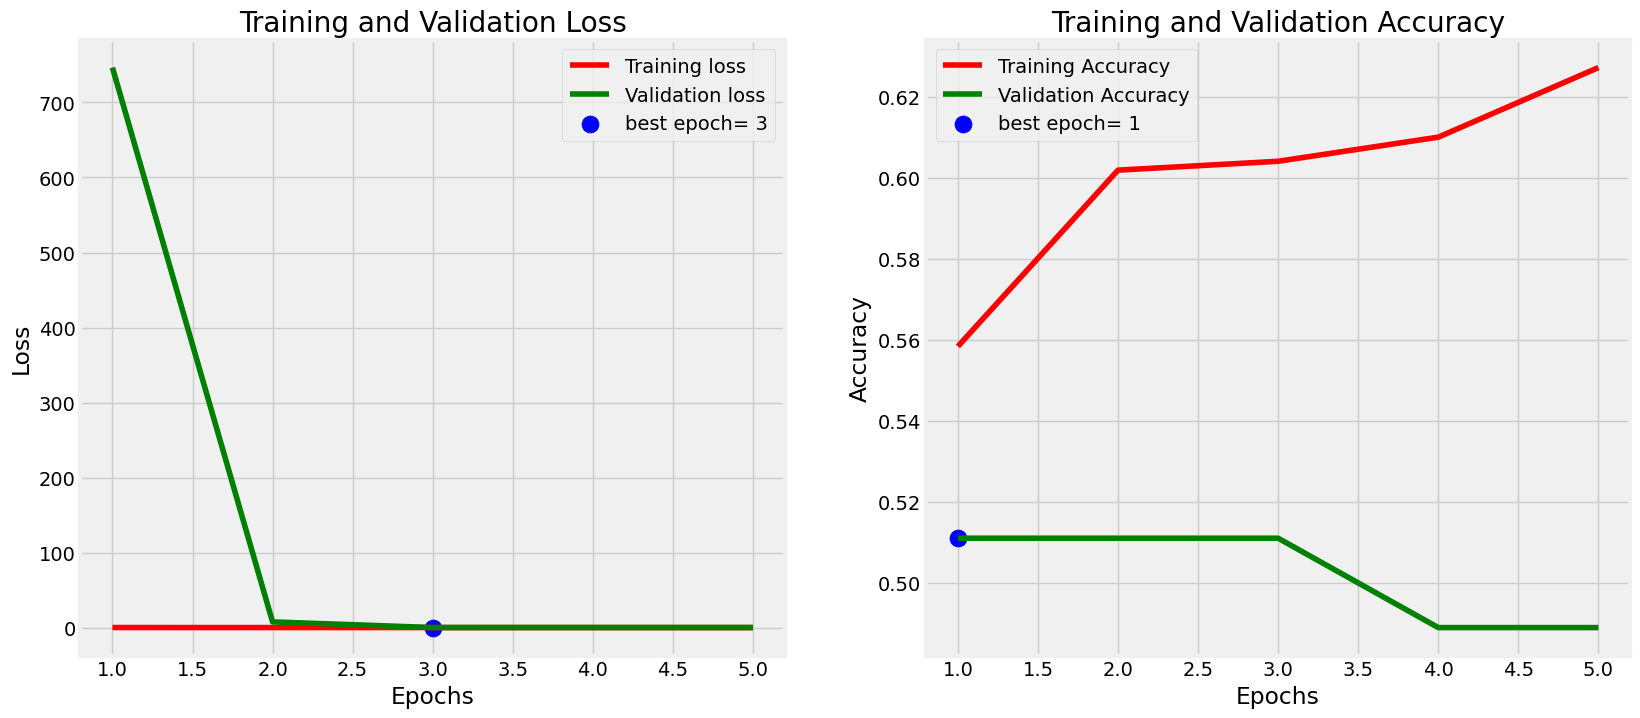

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

1/1 [==============================] - 1s 1s/step
abnormal


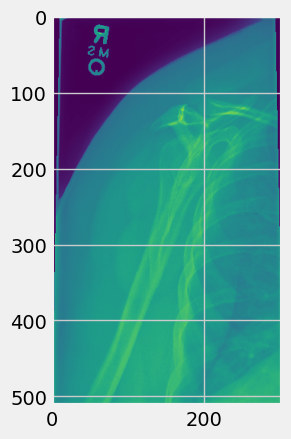

In [ ]:
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


model = load_model('/content/SHOULDER.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = cv2.imread('/content/MURA-v1.1/valid/XR_SHOULDER/patient11186/study1_positive/image1.png')

img= resize(img,(224,224,3))

x=[]
x.append(img)
x=np.array(x)/255.0

classes = model.predict(x)

for i in classes :
    if i[0]>i[1]:
        print ("abnormal")
    else:
        print ("normal")
img_s = mpimg.imread(img_path)
imgplot = plt.imshow(img_s)
plt.show()

In [ ]:
#history=model.fit_generator(generator=my_training_batch_generator,
                   #steps_per_epoch = int(training_data // batch_size),
                   #epochs = 18,
                   #verbose = 1,
                   #class_weight=d_class_weights,
                   #validation_data = my_validation_batch_generator,
                   #validation_steps = int(validation_data // batch_size),
                   #callbacks=my_callbacks)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


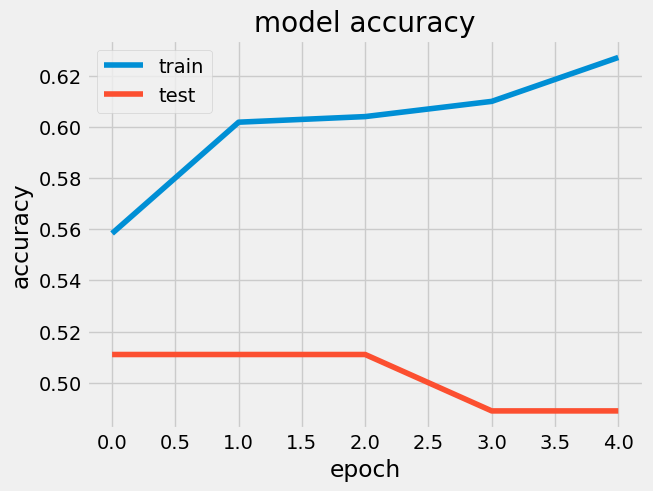

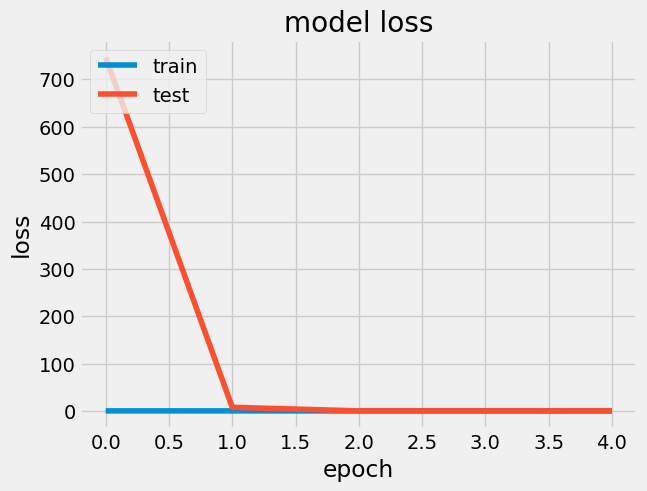

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])
<ipython-input-10-19ef2a2aa6c8>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).ast

18/18 [==============================] - 59s 3s/step
(563, 2) (563, 2)
Final result:  0.0


(563,)

In [ ]:
# list all data in history
print(history.history.keys())
# history.history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# save to json:
hist_json_file = 'history.json'
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv:
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


# convert the model.get_weights() dict to a pandas DataFrame:
model_weights_df = pd.DataFrame(model.get_weights())

# save to json:
model_weights_file = 'XR_SHOULDER-model_weights.json'
with open(hist_json_file, mode='w') as f:
    model_weights_df.to_json(f)

# or save to csv:
model_weights_file = 'XR_SHOULDER-model_weights.csv'
with open(hist_csv_file, mode='w') as f:
    model_weights_df.to_csv(f)

# model.save('MURA_model@XR_WRIST.h5')
m = tfa.metrics.CohenKappa(num_classes=2,sparse_labels=False)
# model=tf.keras.models.load_model(path)
y_pred=  model.predict(my_validation_batch_generator)

yp2 = np.argmax(y_pred,axis = 1)
ya2 = np.argmax(vy_data,axis = 1)
print(y_pred.shape,vy_data.shape)
m.update_state(ya2, yp2)
print('Final result: ', m.result().numpy())

vy_data2 = np.argmax(vy_data,axis=1)
vy_data2.shape

yp2.shape

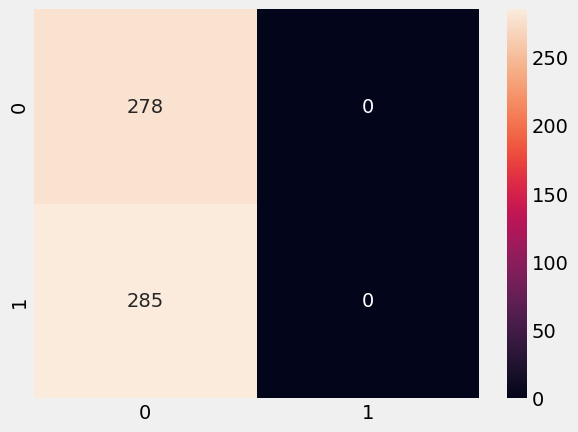

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      1.00      0.66       278
           1       0.00      0.00      0.00       285

    accuracy                           0.49       563
   macro avg       0.25      0.50      0.33       563
weighted avg       0.24      0.49      0.33       563



<ipython-input-10-19ef2a2aa6c8>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


262/262 [==============================] - 817s 3s/step


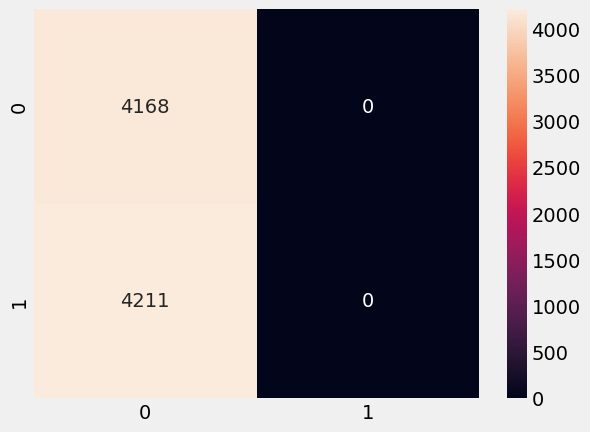

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4168
           1       0.00      0.00      0.00      4211

    accuracy                           0.50      8379
   macro avg       0.25      0.50      0.33      8379
weighted avg       0.25      0.50      0.33      8379



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

cm = confusion_matrix(vy_data2,yp2)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()


print(classification_report(vy_data2,yp2))

y_pred=  model.predict(my_training_batch_generator)
yp3 = np.argmax(y_pred,axis=1)
y_true3 = np.argmax(y_data,axis=1)
cm2 = confusion_matrix(y_true3,yp3)
sn.heatmap(cm2,annot=True,fmt='d')
plt.show()

print(classification_report(y_true3,yp3))

In [ ]:
m = tfa.metrics.CohenKappa(num_classes=2,sparse_labels=False)
model=tf.keras.models.load_model(checkpoint_path)
y_pred=  model.predict(my_validation_batch_generator)
y_pred


<ipython-input-10-19ef2a2aa6c8>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


18/18 [==============================] - 57s 3s/step
